In [78]:
!pip install --upgrade --no-cache-dir git+https://github.com/rongardF/tvdatafeed.git

  Cloning https://github.com/rongardF/tvdatafeed.git to /tmp/pip-req-build-1wkamgml
  Running command git clone --filter=blob:none --quiet https://github.com/rongardF/tvdatafeed.git /tmp/pip-req-build-1wkamgml
  Resolved https://github.com/rongardF/tvdatafeed.git to commit e6f6aaa7de439ac6e454d9b26d2760ded8dc4923
  Preparing metadata (setup.py) ... done


In [79]:
import math
def CRRTree(K,T,S,sig,r,N,PorC):

    dt=T/N;
    dxu=math.exp((r-(sig**2/2))*dt+sig*math.sqrt(dt));
    dxd=math.exp((r-(sig**2/2))*dt-sig*math.sqrt(dt));
    #risk-neutral evaluation
    pu=0.5;
    pd=1-pu;
    disc=math.exp(-r*dt);

    St = [0] * (N+1)
    C = [0] * (N+1)

    St[0]=S*dxd**N;

    for j in range(1, N+1):
        St[j] = St[j-1] * dxu/dxd;

    for j in range(1, N+1):
        if PorC == 'p':
            C[j] = max(K-St[j],0);
        elif PorC == 'c':
            C[j] = max(St[j]-K,0);

    for i in range(N, 0, -1):
        for j in range(0, i):
            C[j] = disc*(pu*C[j+1]+pd*C[j]);
    return C[0]

In [80]:
import math

def fnor2(x):

    y=0.5*(1+math.erf(x/math.sqrt(2)));

    return y

def BS(t,St,K,T,r,sig,PorC):

    Tmt=T-t;
    ATmt=sig*math.sqrt(Tmt);
    logo=math.log(St/K);
    Ap=(logo+(r+0.5*sig**2)*Tmt)/ATmt;
    An=Ap-ATmt;

    if PorC == 'c':
        p=St*fnor2(Ap)-K*math.exp(-r*Tmt)*fnor2(An);
    elif PorC == 'p':
        p=K*math.exp(-r*Tmt)*fnor2(-An)-St*fnor2(-Ap);

    return p

In [85]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')  #To ignore log in warnings
from tvDatafeed import TvDatafeed, Interval ##used to get the historical data
import random
import dataframe_image as dfi

## top 10 stocks
n50=np.array(['NIFTY','HINDALCO','MARUTI','NESTLEIND', 'ONGC', 'TATAMOTORS','ITC','SUNPHARMA','BHARATIARTL','CIPLA'])

def predict(bt_N,b):
  result=pd.DataFrame(columns=['Date','Start', 'Strike', 'Market Premium', 'BS Premium', 'BT Premium', 'BS Error', 'BT Error', 'BS Percent Error', 'BT Percent Error'])
  tv=TvDatafeed()
  data=tv.get_hist(symbol=n50[b],exchange='NSE',interval=Interval.in_daily,n_bars=1100)
  df=pd.DataFrame(data)
  vd=252 ##offset for volatility
  rf=0.0695  ## risk free rate
  df=df.drop(['symbol','high','low','volume'],axis=1)
  df.reset_index(inplace=True)
  df['datetime']=pd.to_datetime(df['datetime'])
  df['day_of_week']=df['datetime'].dt.day_of_week ## if day of week is 3, it is thursday
  df['date']=df['datetime'].dt.day
  df['daily_return']=np.log(df['close']/df['open'])
  #The data of the Stock displayed
  # display(df.head())
  act_index=[]
  for i in range(1080-vd):
    if df.loc[i+vd,'date'] > df.loc[i+vd+1,'date']:
      flag=False
      for j in range(5):
        if df.loc[i+vd-j,'day_of_week'] == 3:
          act_index.append(i+vd-j)
          flag=True
          break
      ## incase the given thursadayis a holiday, we would check on the friday. this ensures that we dont skip any month
      ## due to lack of thursday data in the dataframe
      if flag==False:
        for j in range(5):
          if df.loc[i+vd-j,'day_of_week'] == 4:
            act_index.append(i+vd-j)
            flag=True
            break
  #print(len(act_index))
  #print(df.loc[act_index])
  #print(df[410:420])
  ## now calculating for each index/month

  volatil=pd.DataFrame(columns=['Date','Volatility'])
  for e in range(39):
    start_index=act_index[e]
    start_price=df.loc[start_index,'open']

    #Volatility Calculation
    vol=df.loc[start_index-252:start_index,'daily_return']
    vol=vol.to_numpy()
    sigma=vol.std()*np.sqrt(252)
    volatil.loc[len(volatil)] ={
      'Date': df.loc[start_index + 1, 'datetime'],
      'Volatility': sigma
    }
    #print(sigma)

    #Calculation for different possible strike prices
    for num_of_sps in range(-3,4):
      strike_price=start_price+num_of_sps*(start_price/10)
      bs_premium=BS(0,start_price,strike_price,1.0/12,rf,sigma,'c')
      bt_premium=CRRTree(strike_price,1.0/12,start_price,sigma,rf,bt_N,'c')
      market_premium=max(0,df.loc[start_index+1,'open']-strike_price)
      bs_error = abs(bs_premium - market_premium)
      bt_error = abs(bt_premium - market_premium)
      bs_percent_error = 0
      bt_percent_error = 0
      if market_premium == 0:
        if bs_error >= 10:
          bs_percent_error = 100
        if bt_error >=10:
          bt_percent_error = 100
      else:
        bs_percent_error = min((bs_error / market_premium)*100,100)
        bt_percent_error = min((bt_error / market_premium)*100,100)
      result.loc[len(result)] ={
        'Date': df.loc[start_index + 1, 'datetime'],
        'Start': start_price,
        'Strike': strike_price,
        'Market Premium': market_premium,
        'BS Premium': bs_premium,
        'BT Premium': bt_premium,
        'BS Error': bs_error,
        'BT Error': bt_error,
        'BS Percent Error': bs_percent_error,
        'BT Percent Error': bt_percent_error
      }
  result.set_index('Date', inplace=True)
  volatil.set_index('Date', inplace=True)
  return result,volatil



In [91]:

#Setting the stock to be analysed
b=3
N=6
print(f"\033[1mThe underlying asset is: {n50[b]}\033[0m")


The underlying asset is: NESTLEIND


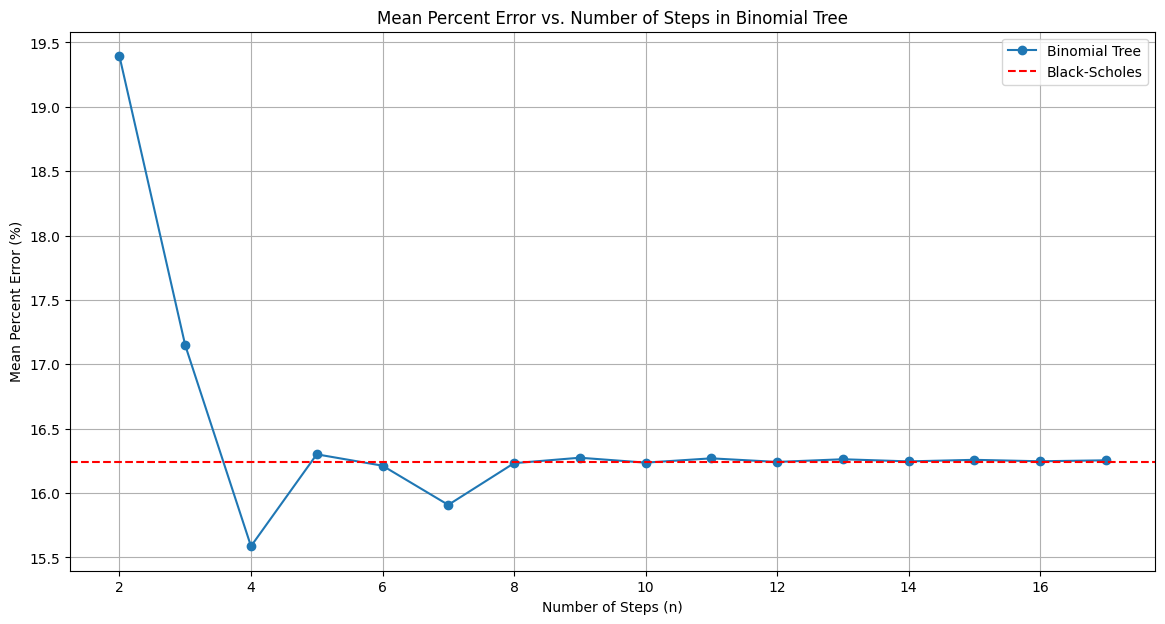

In [87]:

#Plotting performance of binomial tress against the number of steps
n_values = range(2, 18)
bt_mean_percent_errors = []
for n in n_values:
    result = predict(n,b)[0]
    aresult = result.groupby(result.index).mean()
    bt_mean_percent_errors.append(aresult['BT Percent Error'].mean())

# Calculate mean percent error for Black-Scholes
bs_mean_percent_error = aresult['BS Percent Error'].mean()

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(n_values, bt_mean_percent_errors, marker='o', label='Binomial Tree')
plt.axhline(y=bs_mean_percent_error, color='r', linestyle='--', label='Black-Scholes')
plt.xlabel('Number of Steps (n)')
plt.ylabel('Mean Percent Error (%)')
plt.title('Mean Percent Error vs. Number of Steps in Binomial Tree')
plt.legend()
plt.grid(True)
plt.show()


In [88]:

#Result display
result=predict(N,b)[0]
display(result)

aresult = result.groupby(result.index).mean().tail(26)       #Aggregated result of all different strike prices for a single date, for last 2 yrs
display(aresult)


,Start,Strike,Market Premium,BS Premium,BT Premium,BS Error,BT Error,BS Percent Error,BT Percent Error
Date,,,,,,,,,
2021-02-26 03:45:00,1630.60,1141.420,463.630,495.772328,493.126258,32.142328,29.496258,6.932754,6.362025
2021-02-26 03:45:00,1630.60,1304.480,300.570,333.872923,333.541017,33.302923,32.971017,11.079922,10.969497
2021-02-26 03:45:00,1630.60,1467.540,137.510,178.659978,179.210692,41.149978,41.700692,29.925081,30.325571
2021-02-26 03:45:00,1630.60,1630.600,0.000,62.926476,61.000015,62.926476,61.000015,100.000000,100.000000
2021-02-26 03:45:00,1630.60,1793.660,0.000,12.742730,12.800650,12.742730,12.800650,100.000000,100.000000
...,...,...,...,...,...,...,...,...,...
2024-04-26 03:45:00,2519.95,2267.955,306.995,265.693433,265.590741,41.301567,41.404259,13.453498,13.486949
2024-04-26 03:45:00,2519.95,2519.950,55.000,58.397758,57.896723,3.397758,2.896723,6.177742,5.266768
2024-04-26 03:45:00,2519.95,2771.945,0.000,2.072226,1.459052,2.072226,1.459052,0.000000,0.000000


,Start,Strike,Market Premium,BS Premium,BT Premium,BS Error,BT Error,BS Percent Error,BT Percent Error
Date,,,,,,,,,
2022-04-01 03:45:00,1725.0000,1725.0000,155.317200,157.659046,156.478471,6.522331,7.364841,14.919091,15.142534
2022-04-29 03:45:00,1823.8500,1823.8500,166.130000,166.418282,165.179365,7.619341,8.582484,15.372000,15.599701
2022-05-27 03:45:00,1743.5000,1743.5000,167.442857,159.432786,158.234934,11.891319,12.721127,8.233428,8.226012
2022-07-01 03:45:00,1749.9051,1749.9051,145.746823,160.051282,158.846973,14.304459,13.100150,17.217308,16.983101
2022-07-29 03:45:00,1857.5000,1857.5000,189.922857,170.192902,168.928996,20.505295,21.514688,6.842815,7.205239
2022-08-26 03:45:00,1967.1000,1967.1000,162.994286,180.108914,178.746133,17.114629,15.751847,17.525828,17.292732
2022-09-30 03:45:00,1893.5199,1893.5199,163.147477,172.981523,171.689279,9.834045,8.541802,15.387637,15.156387
2022-10-28 03:45:00,2046.8500,2046.8500,161.076429,187.415992,185.998987,26.339564,24.922559,20.713365,20.469618
2022-11-25 03:45:00,1962.5000,1962.5000,178.214286,179.537173,178.183787,8.319149,9.232730,15.238541,15.458252


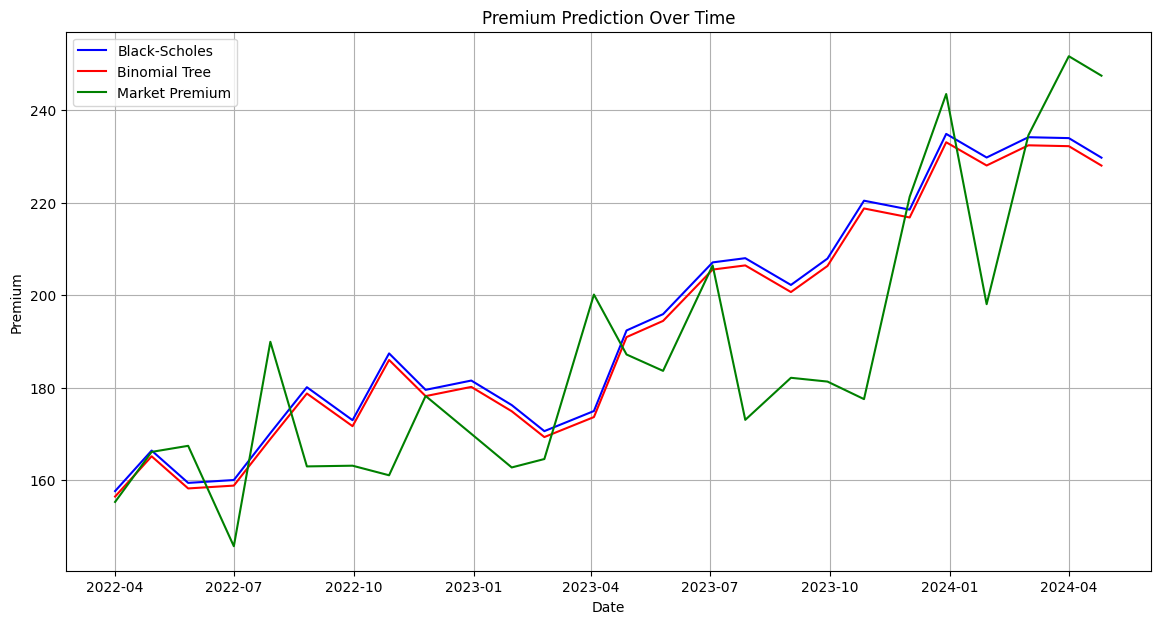

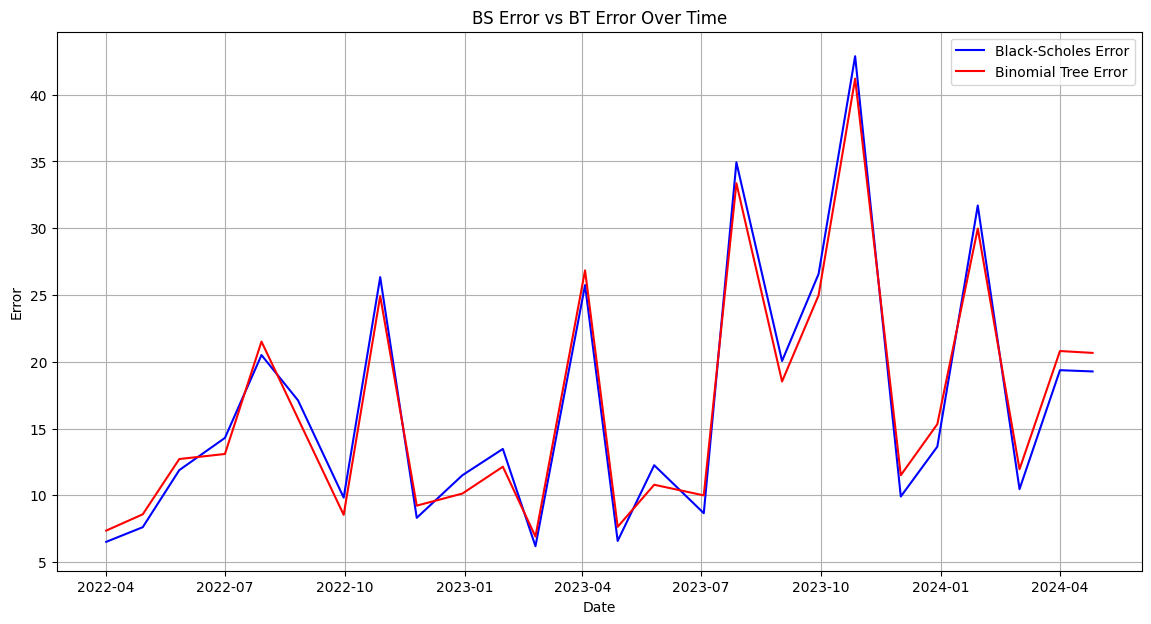

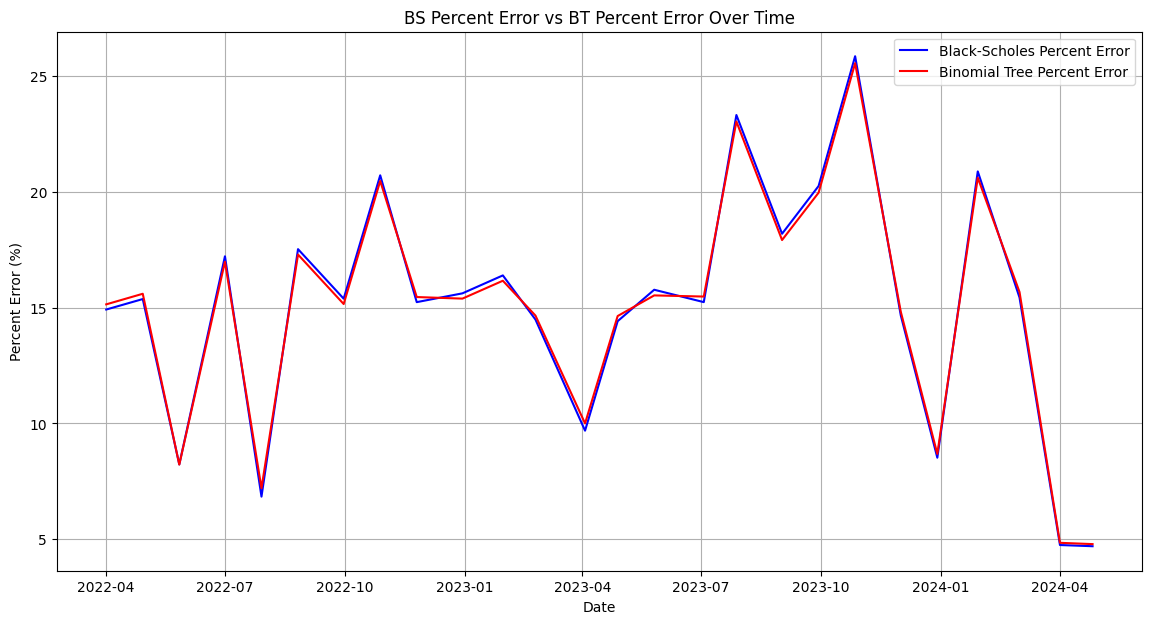

Mean Error Black-Scholes:  15.485034399493667
Mean Error Binomial:  15.304839036057254
Mean Percent Error Black-Scholes:  16.241345339940814
Mean Percent Error Binomial:  16.212837989817192


In [89]:

# Plotting premium prediction vs market premium
plt.figure(figsize=(14, 7))
plt.plot(aresult.index, aresult['BS Premium'], label='Black-Scholes', color='blue')
plt.plot(aresult.index, aresult['BT Premium'], label='Binomial Tree', color='red')
plt.plot(aresult.index, aresult['Market Premium'], label='Market Premium', color='green')
plt.xlabel('Date')
plt.ylabel('Premium')
plt.title('Premium Prediction Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the errors vs time
plt.figure(figsize=(14, 7))
plt.plot(aresult.index, aresult['BS Error'], label='Black-Scholes Error', color='blue')
plt.plot(aresult.index, aresult['BT Error'], label='Binomial Tree Error', color='red')
plt.xlabel('Date')
plt.ylabel('Error')
plt.title('BS Error vs BT Error Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the percent errors vs time
plt.figure(figsize=(14, 7))
plt.plot(aresult.index, aresult['BS Percent Error'], label='Black-Scholes Percent Error', color='blue')
plt.plot(aresult.index, aresult['BT Percent Error'], label='Binomial Tree Percent Error', color='red')
plt.xlabel('Date')
plt.ylabel('Percent Error (%)')
plt.title('BS Percent Error vs BT Percent Error Over Time')
plt.legend()
plt.grid(True)
plt.show()

print("Mean Error Black-Scholes: ", result['BS Error'].mean())
print("Mean Error Binomial: ", result['BT Error'].mean())
print("Mean Percent Error Black-Scholes: ", result['BS Percent Error'].mean())
print("Mean Percent Error Binomial: ", result['BT Percent Error'].mean())


,Volatility
Date,
2022-04-01 03:45:00,0.186458
2022-04-29 03:45:00,0.179649
2022-05-27 03:45:00,0.188556
2022-07-01 03:45:00,0.189377
2022-07-29 03:45:00,0.196332
2022-08-26 03:45:00,0.193607
2022-09-30 03:45:00,0.184584
2022-10-28 03:45:00,0.193714
2022-11-25 03:45:00,0.190296


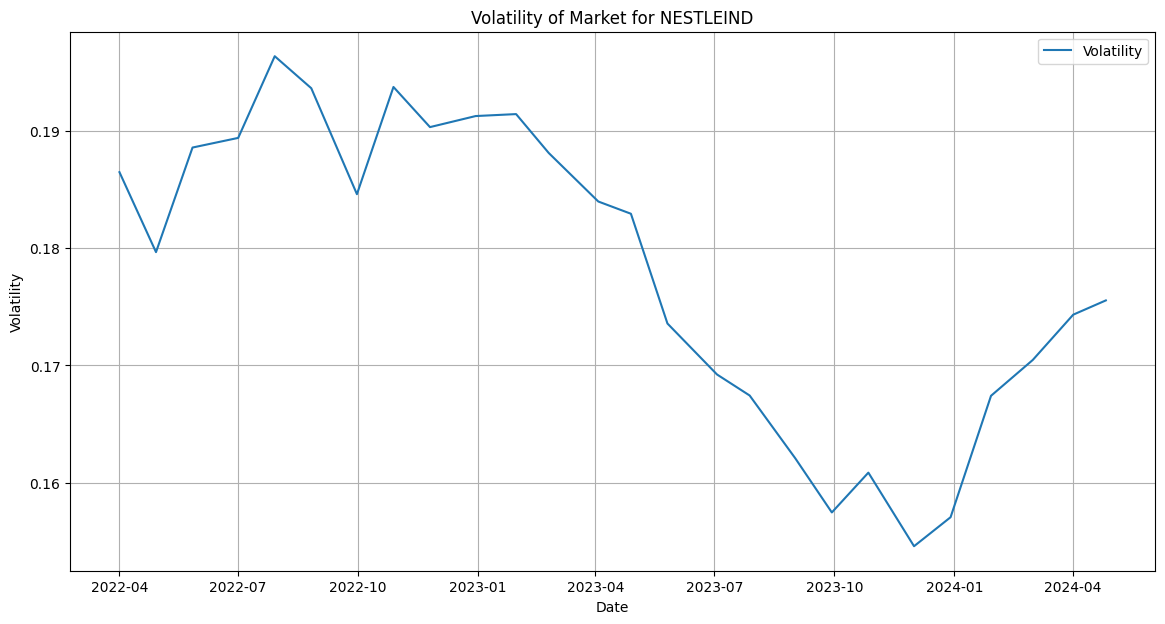

In [92]:

# Plotting the results

#Volatility of Market for the stock
volatil=predict(N,b)[1].tail(26)
display(volatil)
plt.figure(figsize=(14, 7))
plt.plot(volatil.index, volatil['Volatility'], label='Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title(f'Volatility of Market for {n50[b]}')
plt.legend()
plt.grid(True)
plt.show()


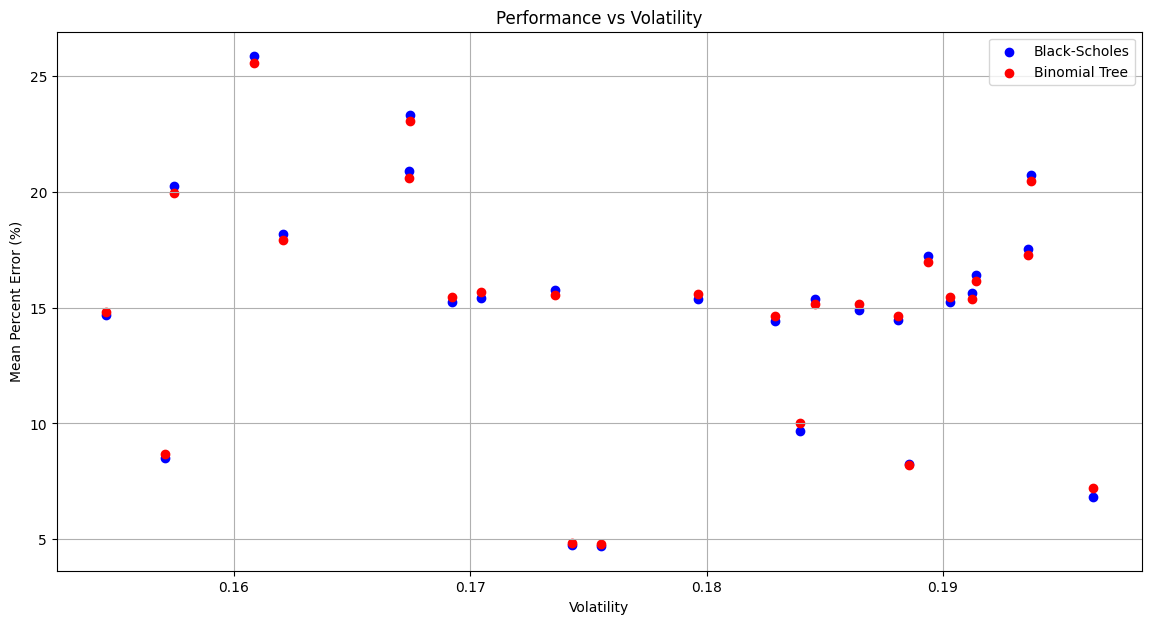

In [90]:

# Plot performance vs volatility
plt.figure(figsize=(14, 7))
plt.scatter(volatil['Volatility'], aresult['BS Percent Error'], label='Black-Scholes', color='blue')
plt.scatter(volatil['Volatility'], aresult['BT Percent Error'], label='Binomial Tree', color='red')
plt.xlabel('Volatility')
plt.ylabel('Mean Percent Error (%)')
plt.title('Performance vs Volatility')
plt.legend()
plt.grid(True)
plt.show()